In [36]:
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import tqdm

%matplotlib inline

pyro.set_rng_seed(42)

## Model 1 - Indirect Race Path

### Read data

In [29]:
# race
df = pd.read_csv('data/model1_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model1_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model1_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )



# c_charge_degree
df = pd.read_csv('data/model1_c_charge_degree.csv')
c_charge_degree_alias = list(set( df['c_charge_degree'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['c_charge_degree'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in c_charge_degree_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

c_charge_degree_probs = torch.tensor( l0 )

# two_year_recid
df = pd.read_csv('data/model1_two_year_recid.csv')
two_year_recid_alias = list(df['Unnamed: 0'])

l = []
for e in c_charge_degree_alias:
    l += [ list( df[e] )  ]
two_year_recid_probs = torch.tensor( l )

### Define Model

In [30]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    c_charge_degree = pyro.sample("c_charge_degree", dist.Categorical(c_charge_degree_probs[race][sex][age_cat]))
    two_year_recid_prob = dist.Categorical(two_year_recid_probs[c_charge_degree])
    two_year_recid = pyro.sample("two_year_recid", two_year_recid_prob)
    return two_year_recid

### Intervention

In [40]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]


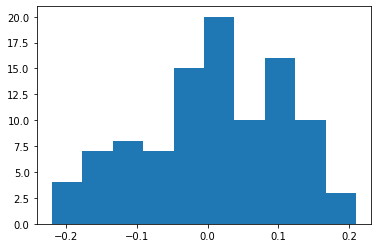

In [41]:
plt.hist(ls)
plt.show()

### Counterfactual fairness

P(two_year_recid race=0 = 1 | race = 1, two_year_recid = 0)

In [38]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:05<00:00, 19.11it/s]


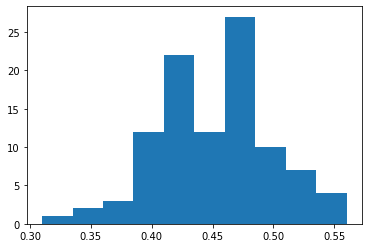

In [39]:
plt.hist(ls) 
plt.show()

### Natural Effects

#### Natural Indirect Effect

In [37]:
# When Z = 1 E(Y|(X = 1), do(M = 1)) - E(Y|(X = 1), do(M = 0))
cond_model = pyro.condition(model, data={'race': torch.tensor(1)})
e1_samples = [pyro.do(cond_model, data={'c_charge_degree': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'c_charge_degree': torch.tensor(0)})() for _ in range(1000)]

In [39]:
e1_avg = sum(e1_samples) / len(e1_samples)
e2_avg = sum(e2_samples) / len(e2_samples)

In [40]:
e1_avg - e2_avg

tensor(-0.1160)

## Model 2 - Direct Race Path

### Read data

In [42]:
# race
df = pd.read_csv('data/model2_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model2_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model2_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )

# c_charge_degree
df = pd.read_csv('data/model2_c_charge_degree.csv')
c_charge_degree_alias = list(set( df['c_charge_degree'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['sex'],row['age_cat'],row['c_charge_degree'])] = row['Freq']
l0 = []
for r in race_alias:
    l1 = []
    for s in sex_alias:
        l2 = []
        for a in age_cat_alias:
            l3 = []
            for c in c_charge_degree_alias:            
                l3 += [ dic[r,s,a,c] ]
            l2 +=  [ l3 ]
        l1 += [ l2 ]
    l0 += [ l1 ]

c_charge_degree_probs = torch.tensor( l0 )

# two_year_recid
df = pd.read_csv('data/model2_two_year_recid.csv')
two_year_recid_alias = list(set( df['two_year_recid'] ))

dic = {}
for index, row in df.iterrows():
    dic[(row['race'], row['c_charge_degree'],row['two_year_recid'])] = row['Freq']
    
l0 = []
for r in race_alias:
    l1 = []
    for c in c_charge_degree_alias:
        l2 = []
        for t in two_year_recid_alias:
            l2 += [ dic[r,c,t] ]
        l1 += [ l2 ]
    l0 += [ l1 ]

two_year_recid_probs = torch.tensor( l0 )

### Define model

In [43]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    c_charge_degree = pyro.sample("c_charge_degree", dist.Categorical(c_charge_degree_probs[race][sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[race][c_charge_degree]))
    return two_year_recid

### Intervention

You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
where two_year_recid=1 represents recidivism, 
race=0 represents "African-American" 
race=1 represents "Caucasian" 

In [46]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


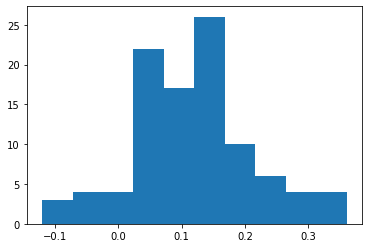

In [47]:
plt.hist(ls) 
plt.show()

### Counterfactual fairness

In [48]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:05<00:00, 17.80it/s]


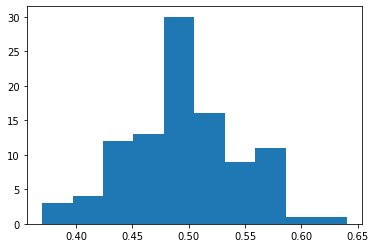

In [49]:
plt.hist(ls)
plt.show()

### Natural effects

#### Natural Direct Effects

In [62]:
# When Z = 1 E(Y|(M = 1), do(X = 1)) - E(Y|(M = 1), do(X = 0))
cond_model = pyro.condition(model, data={'c_charge_degree': torch.tensor(0)})
e1_samples = [pyro.do(cond_model, data={'race': torch.tensor(1)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [63]:
e1_avg = sum(e1_samples) / len(e1_samples)
e2_avg = sum(e2_samples) / len(e2_samples)

In [64]:
e1_avg

tensor(0.4270)

In [65]:
e2_avg

tensor(0.5520)

In [66]:
e1_avg - e2_avg

tensor(-0.1250)

#### Natural Indirect Effects

In [55]:
# NIE = E(Y | M=1, do(X=0)) – E(Y | M=0, do(X=0))
cond_model_1 = pyro.condition(model, data={'c_charge_degree': torch.tensor(1)})
cond_model_2 = pyro.condition(model, data={'c_charge_degree': torch.tensor(0)})
e1_samples = [pyro.do(cond_model_1, data={'race': torch.tensor(0)})() for _ in range(1000)]
e2_samples = [pyro.do(cond_model_2, data={'race': torch.tensor(0)})() for _ in range(1000)]

In [56]:
e1_avg = sum(e1_samples) / len(e1_samples)
e2_avg = sum(e2_samples) / len(e2_samples)

In [57]:
e1_avg - e2_avg

tensor(-0.0810)

## Model 3

### Read data

In [51]:
# race
df = pd.read_csv('data/model3_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model3_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model3_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )

# c_charge_degree
df = pd.read_csv('data/model3_c_charge_degree.csv')
c_charge_degree_alias = list(set( df['c_charge_degree'] ))

dic = {}
for index, row in df.iterrows():
    dic[( row['sex'],row['age_cat'],row['c_charge_degree'])] = row['Freq']
l1 = []
for s in sex_alias:
    l2 = []
    for a in age_cat_alias:
        l3 = []
        for c in c_charge_degree_alias:            
            l3 += [ dic[s,a,c] ]
        l2 +=  [ l3 ]
    l1 += [ l2 ]

c_charge_degree_probs = torch.tensor( l1 )

# two_year_recid
df = pd.read_csv('data/model3_two_year_recid.csv')
two_year_recid_alias = list(df['Unnamed: 0'])

l = []
for e in c_charge_degree_alias:
    l += [ list( df[e] )  ]
two_year_recid_probs = torch.tensor( l )

### Define model

In [52]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    c_charge_degree = pyro.sample("c_charge_degree", dist.Categorical(c_charge_degree_probs[sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[c_charge_degree]))
    return two_year_recid


### Association

In [54]:
df = pd.read_csv('data/compas-scores-two-years-short.csv')

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = c_charge_degree_alias.index( row['c_charge_degree'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "c_charge_degree": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ conditioned_model() ]
    preds += [ pred ]
    if ((index%500)==0):print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

NameError: name 'pred' is not defined

### Intervention

In [9]:
# You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
# where two_year_recid=1 represents recidivism, 
# race=0 represents "African-American" 
# race=0 represents "Caucasian" 

In [55]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:47<00:00,  2.12it/s]


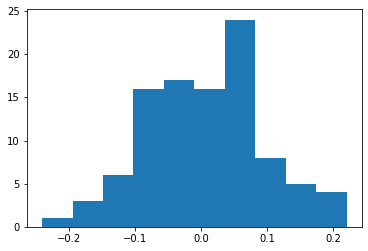

In [56]:
plt.hist(ls)
plt.show()

### Counterfactual fairness

In [62]:
# P(two_year_recid race=0 = 1|race = 1,two_year_recid = 0)

In [64]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:05<00:00, 17.87it/s]


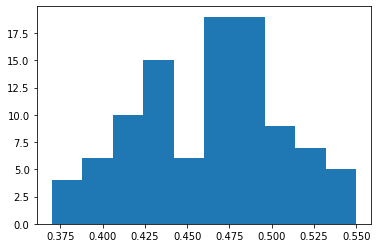

In [65]:
plt.hist(ls)
plt.show()

In [66]:
# P(two_year_recid race=1 = 1|race = 0,two_year_recid = 1)

In [67]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(1)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(1)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:05<00:00, 18.06it/s]


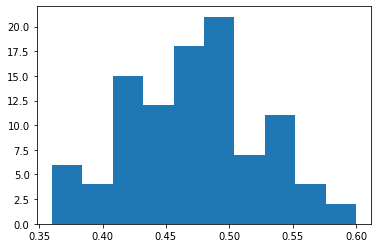

In [68]:
plt.hist(ls)
plt.show()

## Model 4

### Read data

In [69]:
# race
df = pd.read_csv('data/model4_race.csv')
race_alias = list(df['Var1'])
race_prob = torch.tensor(list(df['Freq']) )

# sex
df = pd.read_csv('data/model4_sex.csv')
sex_alias = list(df['Var1'])
sex_prob = torch.tensor(list(df['Freq']) )

# age_cat
df = pd.read_csv('data/model4_age_cat.csv')
age_cat_alias = list(df['Var1'])
age_cat_prob = torch.tensor(list(df['Freq']) )

# c_charge_degree
df = pd.read_csv('data/model4_c_charge_degree.csv')
c_charge_degree_alias = list(set( df['c_charge_degree'] ))

dic = {}
for index, row in df.iterrows():
    dic[( row['sex'],row['age_cat'],row['c_charge_degree'])] = row['Freq']
l1 = []
for s in sex_alias:
    l2 = []
    for a in age_cat_alias:
        l3 = []
        for c in c_charge_degree_alias:            
            l3 += [ dic[s,a,c] ]
        l2 +=  [ l3 ]
    l1 += [ l2 ]

c_charge_degree_probs = torch.tensor( l1 )

# two_year_recid
df = pd.read_csv('data/model4_two_year_recid.csv')
two_year_recid_alias = list(df['Unnamed: 0'])

l = []
for e in c_charge_degree_alias:
    l += [ list( df[e] )  ]
two_year_recid_probs = torch.tensor( l )

### Define model

In [70]:
def model():
    race = pyro.sample("race", dist.Categorical( race_prob )) 
    sex = pyro.sample("sex", dist.Categorical( sex_prob )) 
    age_cat = pyro.sample("age_cat", dist.Categorical( age_cat_prob )) 
    c_charge_degree = pyro.sample("c_charge_degree", dist.Categorical(c_charge_degree_probs[sex][age_cat]))
    two_year_recid = pyro.sample("two_year_recid", dist.Categorical(two_year_recid_probs[c_charge_degree]))

### Association

In [72]:
df = pd.read_csv('compas-scores-two-years_short.csv')

truth = []
preds = []
num_sample = 10
for index, row in df.iterrows():
    r = race_alias.index( row['race'] ) 
    s = sex_alias.index( row['sex'] ) 
    a = age_cat_alias.index( row['age_cat'] ) 
    c = c_charge_degree_alias.index( row['c_charge_degree'] ) 
    t = two_year_recid_alias.index( row['two_year_recid'] ) 
    conditioned_model = pyro.condition(model, data = {"race": torch.tensor( r ),
                                                      "sex": torch.tensor( s ),
                                                      "age_cat": torch.tensor( a ),
                                                      "c_charge_degree": torch.tensor( c )
                                                     })
    posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
    trace = posterior()
    pred = int(trace.nodes['two_year_recid']['value'])
    truth += [ t ]
    preds += [ pred ]
#     if ((index%500)==0):
#         print(index//500)
truth = np.array(truth)
preds = np.array(preds)

# score for Black defendants
y_test_ = truth[ df['race']=='African-American' ]
y_pred_ = preds[ df['race']=='African-American' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("False positive rate (Black)      : ", fp/(fp+tn))
print("False negative rate (Black)      : ", fn/(fn+tp))
print("Accuracy (Black)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (Black)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_black = fp/(fp+tn)
fnr_black =  fn/(fn+tp)

# score for White defendants
y_test_ = truth[ df['race']=='Caucasian' ]
y_pred_ = preds[ df['race']=='Caucasian' ]
[[tn , fp],[fn , tp]]  = confusion_matrix(y_test_, y_pred_)
print("\nFalse positive rate (White)      : ", fp/(fp+tn))
print("False negative rate (White)      : ", fn/(fn+tp))
print("Accuracy (White)      :  ", accuracy_score(y_test_, y_pred_) )
print("AUC (White)      :  ", roc_auc_score(y_test_, y_pred_) )

fpr_white = fp/(fp+tn)
fnr_white =  fn/(fn+tp)

print('\nFalse positive rate Gap:', abs(fpr_black-fpr_white))
print('False negative rate Gap:', abs(fnr_black-fnr_white))

False positive rate (Black)      :  0.5935231714126187
False negative rate (Black)      :  0.39498933901918976
Accuracy (Black)      :   0.5080447232069811
AUC (Black)      :   0.5057437447840958

False positive rate (White)      :  0.5963611859838275
False negative rate (White)      :  0.3970893970893971
Accuracy (White)      :   0.482011447260834
AUC (White)      :   0.5032747084633877

False positive rate Gap: 0.0028380145712088023
False negative rate Gap: 0.0021000580702073557


### Intervention

In [9]:
# You are interested in the average causal effect P(two_year_recid = 1|do(race = 0)) − P(two_year_recid = 1|do(race = 1)),
# where two_year_recid=1 represents recidivism, 
# race=0 represents "African-American" 
# race=0 represents "Caucasian" 

In [72]:
ls = []
for run in tqdm.tqdm(range(100)):
    num_sample = 100
    P_y1_do = {}
    for x in [0,1]:
        do_model = pyro.do(model, data={ 'race': torch.tensor( x )  })
        posterior = pyro.infer.Importance(do_model, num_samples=num_sample).run()
        marginal = pyro.infer.EmpiricalMarginal(posterior, "two_year_recid") 
        samples = np.array([marginal().item() for _ in range(num_sample)])
        e_unique, e_counts = np.unique(samples, return_counts=True)
        dic = dict( zip(e_unique, e_counts) )
        P_y1_do[ x ] = dic[ 1 ] / num_sample
    diff = P_y1_do[0] - P_y1_do[1]
    ls += [ diff ]

100%|██████████| 100/100 [00:49<00:00,  2.04it/s]


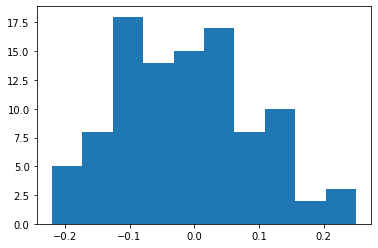

In [73]:
plt.hist(ls)
plt.show()

### Counterfactual fairness

In [11]:
# P(two_year_recid race=0 = 1|race = 1,two_year_recid = 0)

In [74]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(1), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:05<00:00, 18.52it/s]


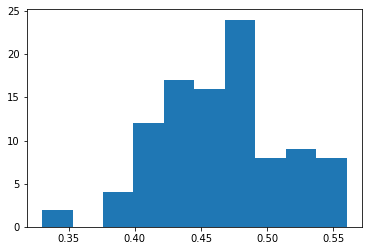

In [75]:
plt.hist(ls)
plt.show()

In [22]:
# P(two_year_recid race=1 = 1|race = 0,two_year_recid = 0)

In [76]:
num_sample = 100
conditioned_model = pyro.condition(model, data = {"race": torch.tensor(0), "two_year_recid": torch.tensor(0)})
posterior = pyro.infer.Importance(conditioned_model, num_samples=num_sample).run()
ls = []
for run in tqdm.tqdm(range(100)):
    z = 0
    for _ in range(num_sample):
        trace = posterior()
        s = trace.nodes['sex']['value']
        a = trace.nodes['age_cat']['value']
        c = trace.nodes['c_charge_degree']['value']
        do_model = pyro.do(model, data = {"race": torch.tensor(0)})
        counterfactual_model = pyro.condition(do_model, data = {'sex': s,'age_cat': a, 'c_charge_degree': c })
        trace_counterfactual = pyro.poutine.trace(counterfactual_model)
        trace = trace_counterfactual.get_trace()
        z += trace.nodes['two_year_recid']['value']
    ls += [ float(z)/num_sample ]

100%|██████████| 100/100 [00:05<00:00, 18.71it/s]


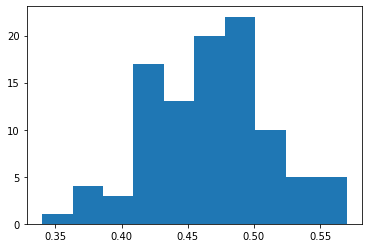

In [77]:
plt.hist(ls)
plt.show()